In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from scipy.stats import logistic
# from scipy.special import logit

import torch
# import torch.nn.functional as F
# from torchvision import transforms
# from torch.utils.data import Dataset
# from torch.cuda.amp import autocast, GradScaler

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.sampling_tram_data import *




Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "tramdag_paper_exp_6_2_mixed"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Loaded existing configuration from /home/bule/TramDag/dev_experiment_logs/tramdag_paper_exp_6_2_mixed/configuration.json


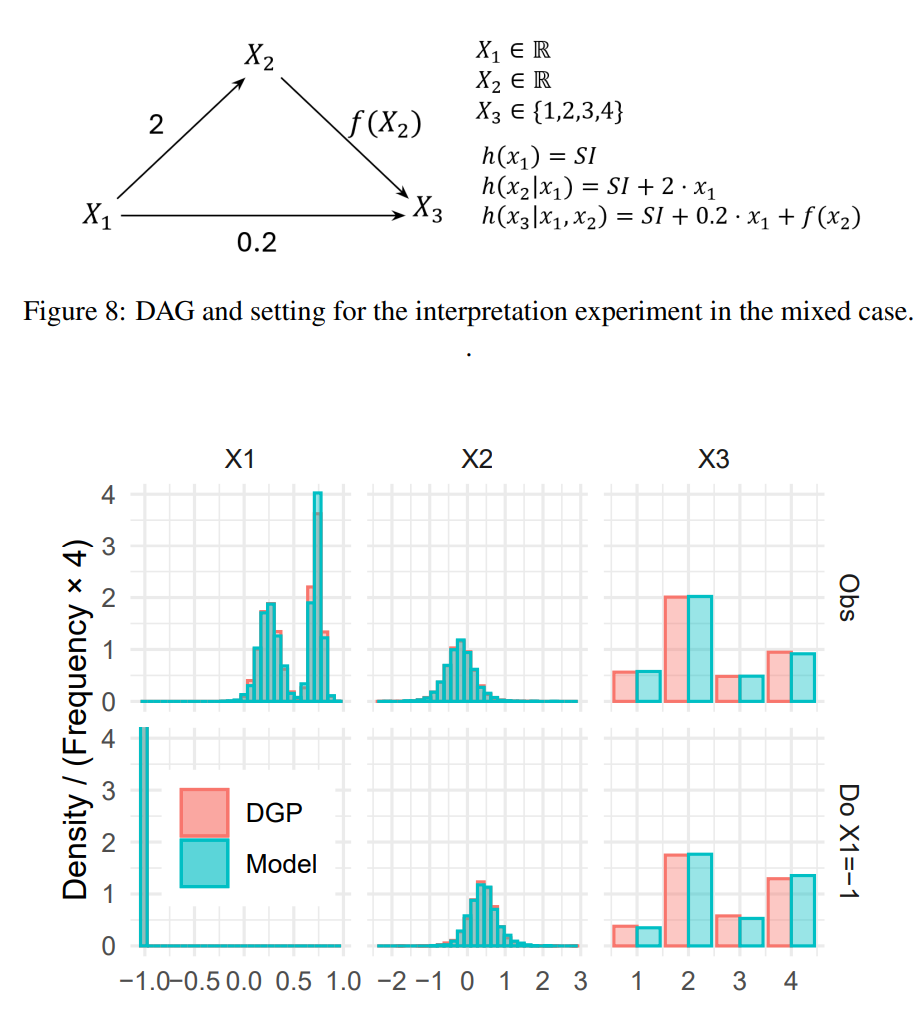

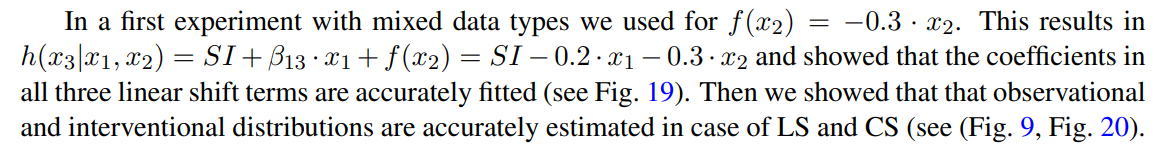

# 2.  Data

Setting seed: 42
         x1        x2 x3
0  0.299671 -0.274509  2
1  0.236174  0.463615  2
2  0.314769 -0.265411  2
3  0.699038  0.013699  2
4  0.226585 -0.117170  2
x3
1    11259
2    46382
3    13362
4    28997
Name: count, dtype: int64


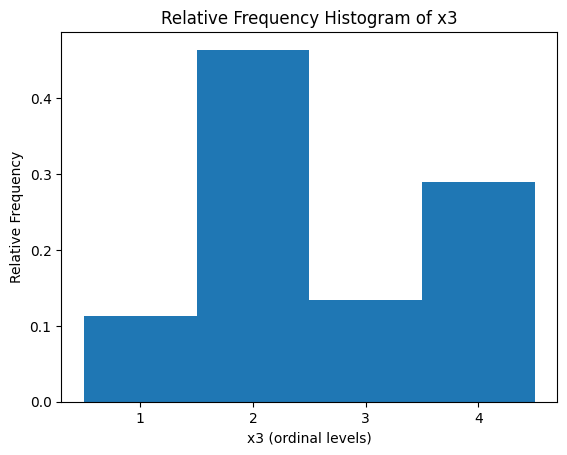

Loaded data from /home/bule/TramDag/dev_experiment_logs/tramdag_paper_exp_6_2_mixed/tramdag_paper_exp_6_2_mixed.csv
Configuration updated successfully.


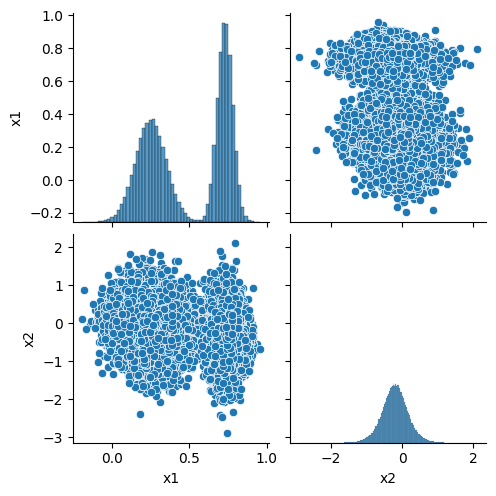

In [3]:


def dgp(n_obs, doX=[None, None, None], f=lambda x: x, seed=None):
    """
    Data-generating process matching the provided R implementation.
    
    Parameters
    ----------
    n_obs : int
        Number of observations to generate.
    doX : list of length 3
        If doX[i] is not None, fixes X_{i+1} to that constant for all draws.
    f : callable
        A function of X2 used in generating X3 (defaults to identity).
    seed : int or None
        If provided, sets the NumPy random seed.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['x1', 'x2', 'x3'], where x3 is an ordered
        categorical with levels 1 < 2 < 3 < 4.
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Setting seed: {seed}")

    # --- 1. Sample X1 from a 2-component GMM ---
    if doX[0] is None:
        X1_A = np.random.normal(loc=0.25, scale=0.10, size=n_obs)
        X1_B = np.random.normal(loc=0.73, scale=0.05, size=n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, X1_A, X1_B)
    else:
        x1 = np.full(n_obs, doX[0], dtype=float)

    # --- 2. Sample X2 via shifted-logit inversion (as in R) ---
    if doX[1] is None:
        # draw U2 ~ Uniform(0,1) and map through quantile of logistic
        u2 = np.random.uniform(size=n_obs)
        z2 = np.log(u2 / (1 - u2))  # qlogis
        # replicate: X2 = (z2 - 2 * x1) / 5
        x2 = (z2 - 2 * x1) / 5.0
    else:
        x2 = np.full(n_obs, doX[1], dtype=float)

    # --- 3. Sample X3 as an ordinal via logistic thresholds ---
    if doX[2] is None:
        # latent U3 ~ Logistic(0,1)
        u3 = np.random.logistic(loc=0.0, scale=1.0, size=n_obs)
        # thresholds theta_k = (-2, 0.42, 1.02)
        theta = np.array([-2.0, 0.42, 1.02])
        # compute h[i,k] = theta_k + 0.2 * x1[i] + f(x2[i])
        # result shape (n_obs, 3)
        h = theta + 0.2 * x1.reshape(-1, 1) + f(x2).reshape(-1, 1)
        # assign x3 starting at 1
        x3 = np.ones(n_obs, dtype=int)
        x3[u3 > h[:, 0]] = 2
        x3[u3 > h[:, 1]] = 3
        x3[u3 > h[:, 2]] = 4
        # convert to ordered categorical
        x3 = pd.Categorical(x3, categories=[1, 2, 3, 4], ordered=True)
    else:
        x3 = pd.Categorical(
            np.full(n_obs, doX[2], dtype=int),
            categories=[1, 2, 3, 4],
            ordered=True
        )

    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})



df = dgp(n_obs=100000, seed=42)
print(df.head())
print(df['x3'].value_counts().sort_index())

vals = df['x3'].astype(int)

# Define bin edges so each integer gets its own bar
bins = [0.5, 1.5, 2.5, 3.5, 4.5]


plt.hist(vals, bins=bins, density=True)
plt.xticks([1, 2, 3, 4])
plt.xlabel('x3 (ordinal levels)')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram of x3')
plt.show()

import seaborn as sns
sns.pairplot(df)

EXP_DATA_PATH=os.path.join(DATA_PATH, f"{experiment_name}.csv")
if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=100000, seed=42)
    df['x3']=df['x3'].astype(int)
    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    df['x3']=df['x3'].astype(int)
    print(f"Loaded data from {EXP_DATA_PATH}")


data_type= {'x1':'cont','x2':'cont','x3':'ord'} # cont:continous, ord:ordinal, oher:everything else than images

write_data_type_to_configuration(data_type, CONF_DICT_PATH)



## 2.1 train test split

In [4]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# 3. Normalize all sets using training quantiles
def normalize_with_quantiles(df, min_vals, max_vals):
    return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 80000, Validation size: 10000, Test size: 10000


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 75220 to 15795
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      80000 non-null  float64
 1   x2      80000 non-null  float64
 2   x3      80000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.4 MB


In [12]:
train_df['x3']

75220    1
48955    4
44966    2
13568    2
92727    4
        ..
6265     1
54886    3
76820    4
860      1
15795    3
Name: x3, Length: 80000, dtype: int64

# 3. Define graph Structure

- define graph and which shift and intercept terms to use


/home/bule/TramDag/utils/graph.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


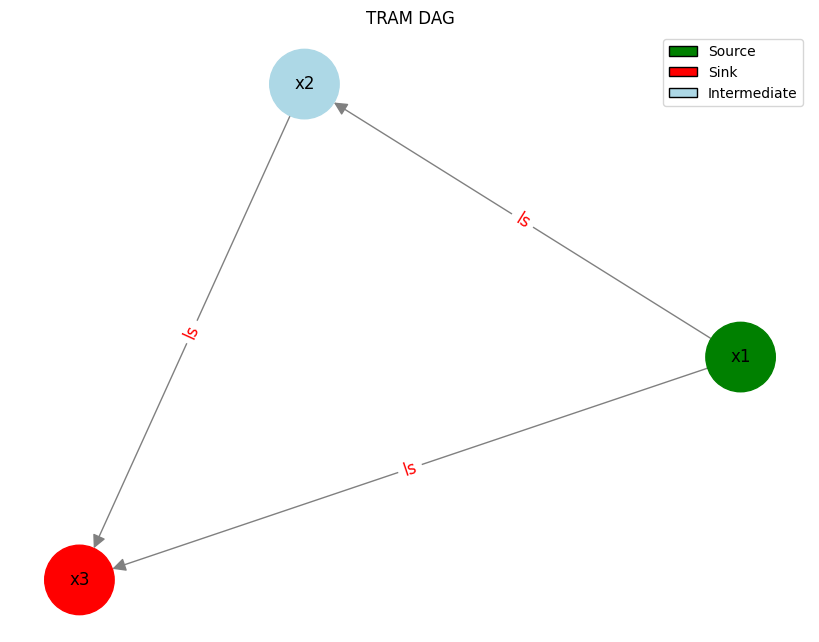

In [5]:
interactive_adj_matrix(CONF_DICT_PATH,seed=10)

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

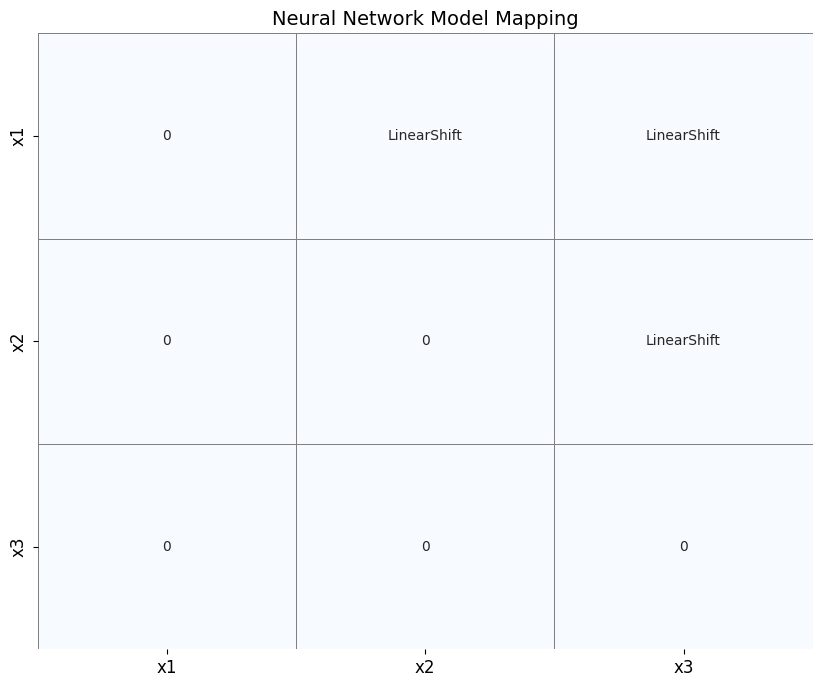

In [6]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [7]:
write_nodes_information_to_configuration_v2(CONF_DICT_PATH, min_vals, max_vals,levels_dict={'x3': 4})

{'x1': {'Modelnr': 0, 'data_type': 'cont', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.12157964485414735, 'max': 0.794303998711493, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'cont', 'node_type': 'internal', 'parents': ['x1'], 'parents_datatype': {'x1': 'cont'}, 'transformation_terms_in_h()': {'x1': np.str_('ls')}, 'min': -0.8069206639187695, 'max': 0.418925659248077, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift')}}, 'x3': {'Modelnr': 2, 'data_type': 'ord', 'levels': 4, 'node_type': 'sink', 'parents': ['x1', 'x2'], 'parents_datatype': {'x1': 'cont', 'x2': 'cont'}, 'transformation_terms_in_h()': {'x1': np.str_('ls'), 'x2': np.str_('ls')}, 'min': 1.0, 'max': 4.0, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift'), 'x2': np.str_('LinearShift')}}}
Configuration updated successfully.


In [8]:
DEV_TRAINING=True
train_list=['x1','x2','x3']#['x2']#'x1','x2']#,'x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 1# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.01
use_scheduler =  False

In [9]:
def check_if_training_complete(node, NODE_DIR, epochs):
    """
    Check if the training for the given node is complete.
    Returns True if training is complete, False otherwise.
    """
    MODEL_PATH, _, TRAIN_HIST_PATH, VAL_HIST_PATH = model_train_val_paths(NODE_DIR)
    try:
        if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_HIST_PATH) and os.path.exists(VAL_HIST_PATH):
            with open(TRAIN_HIST_PATH, 'r') as f:
                train_loss_hist = json.load(f)

            start_epoch = len(train_loss_hist)
            
            # return false if already trained to skip to the next node 
            if start_epoch >= epochs:
                print(f"Node {node} already trained for {epochs} epochs. Skipping.")
                return False
            else:
                print(f"Node {node} not trained yet or training incomplete. Starting from epoch {start_epoch}.")
                return True
        else:
            
            return True
        
    except Exception as e:
        print(f"Error checking training status for node {node}: {e}")
        return False

In [ ]:
## TODO fix odd bug for dataloading with np.int64 


# For each NODE 
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
target_nodes = configuration_dict['nodes']


for node in target_nodes:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (target_nodes[node]['node_type'] == 'source') and (target_nodes[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    
    # Check if training is complete
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    
    ########################## 2. Create Model ##############################
    tram_model = get_fully_specified_tram_model_v2(node, target_nodes, verbose=True).to(device)

    
    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader_v2(node, target_nodes, train_df, val_df, batch_size=batch_size, verbose=True)

    ########################## 5. Optimizer & Scheduler ######################.
    
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
    train_val_loop_v3(
                   node,
                   target_nodes,
                   NODE_DIR,
                   tram_model,
                   train_loader,
                   val_loader,
                   epochs,
                   optimizer,
                   use_scheduler,
                   scheduler,
                   save_linear_shifts=False,
                   verbose=1,
                   device=device)
    



----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Node x1 already trained for 1 epochs. Skipping.

----*----------*-------------*--------------- Node: x2 ------------*-----------------*-------------------*--
Node x2 already trained for 1 epochs. Skipping.

----*----------*-------------*--------------- Node: x3 ------------*-----------------*-------------------*--
Constructed TRAM model: TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=3, bias=False)
  )
  (nn_shift): ModuleList(
    (0-1): 2 x LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)
Parents dtype: OrderedDict([('x1', 'cont'), ('x2', 'cont')])
Min-Max values for x3: tensor([1., 4.], device='cuda:0')
torch.Size([2])
No existing model found. Starting fresh...
y_int: 2y_int: 1y_int: 2y_int: 1



y_int: 2y_int: 2y_int: 2y_int: 4



y_int: 1


AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/bule/TramDag/utils/tram_data.py", line 185, in __getitem__
    print(f'shape: {y_int.shape}')
AttributeError: 'int' object has no attribute 'shape'


In [ ]:
next(iter(train_loader))

In [ ]:
def train_val_loop_v3(
    node,
    target_nodes,
    NODE_DIR,
    tram_model,
    train_loader,
    val_loader,
    epochs,
    optimizer,
    use_scheduler,
    scheduler,
    save_linear_shifts=False,
    verbose=1,
    device='cpu'):

    # get all paths  for this training run
    MODEL_PATH,LAST_MODEL_PATH,TRAIN_HIST_PATH,VAL_HIST_PATH=model_train_val_paths(NODE_DIR)
    
    # this is needed for the preprocessing of the inputs such that they are in the correct order
    _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes)
    
    # this is needed for the scaling if there is a bernstein polynomial for contionous outcomes
    min_vals = torch.tensor(target_nodes[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(target_nodes[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)
    print(f"Min-Max values for {node}: {min_max}")
    print(min_max.shape)
    
    
    ###### Load Model & History #####
    if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_HIST_PATH) and os.path.exists(VAL_HIST_PATH):
        print("Existing model found. Loading weights and history...")
        tram_model.load_state_dict(torch.load(MODEL_PATH))

        with open(TRAIN_HIST_PATH, 'r') as f:
            train_loss_hist = json.load(f)
        with open(VAL_HIST_PATH, 'r') as f:
            val_loss_hist = json.load(f)

        start_epoch = len(train_loss_hist)
        best_val_loss = min(val_loss_hist)
    else:
        print("No existing model found. Starting fresh...")
        train_loss_hist, val_loss_hist = [], []
        start_epoch = 0
        best_val_loss = float('inf')
    
    ##### Training and Validation loop
    for epoch in range(start_epoch, epochs):
        epoch_start = time.time()

        #####  Training #####
        train_start = time.time()
        train_loss = 0.0
        tram_model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            y = y.to(device)
                            
            int_input, shift_list = preprocess_inputs(x, ordered_transformation_terms_in_h.values(), device=device)
            y_pred = tram_model(int_input=int_input, shift_input=shift_list)
            
            # print(f"y_pred shape: {y_pred}, y shape: {y}")
            # print(f'min_max:{min_max}')

            if target_nodes[node]['data_type'] == 'ord':
                loss = ontram_nll(y_pred, y)
                # print("using ontram loss")
            else:
                loss = contram_nll(y_pred, y, min_max=min_max)
            
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        if use_scheduler:
            scheduler.step()
            
        train_time = time.time() - train_start

        avg_train_loss = train_loss / len(train_loader)
        train_loss_hist.append(avg_train_loss)

        ##### Validation #####
        val_start = time.time()
        val_loss = 0.0
        tram_model.eval()
        
        with torch.no_grad():
            for x, y in val_loader:
                y = y.to(device)
                
                int_input, shift_list = preprocess_inputs(x, ordered_transformation_terms_in_h.values(), device=device)
                y_pred = tram_model(int_input=int_input, shift_input=shift_list)
                
                if target_nodes[node]['data_type'] == 'ord':
                    loss = ontram_nll(y_pred, y)
                else:
                    loss = contram_nll(y_pred, y, min_max=min_max)
                
                
                val_loss += loss.item()
        val_time = time.time() - val_start

        avg_val_loss = val_loss / len(val_loader)
        val_loss_hist.append(avg_val_loss)

        ##### Save linear shift weights #####
        
        if save_linear_shifts and tram_model.nn_shift is not None:
            # Define the path for the cumulative JSON file
            shift_path = os.path.join(NODE_DIR, "linear_shifts_all_epochs.json")

            # Load existing data if the file exists
            if os.path.exists(shift_path):
                with open(shift_path, 'r') as f:
                    all_shift_weights = json.load(f)
            else:
                all_shift_weights = {}

            # Prepare current epoch's shift weights
            epoch_weights = {}
            for i in range(len(tram_model.nn_shift)):
                shift_layer = tram_model.nn_shift[i]
                
                if hasattr(shift_layer, 'fc') and hasattr(shift_layer.fc, 'weight'):
                    epoch_weights[f"shift_{i}"] = shift_layer.fc.weight.detach().cpu().tolist()
                else:
                    print(f"shift_{i}: 'fc' or 'weight' layer does not exist.")
            
            # Add to the dictionary under current epoch
            all_shift_weights[f"epoch_{epoch+1}"] = epoch_weights
            
            # Write back the updated dictionary
            with open(shift_path, 'w') as f:
                json.dump(all_shift_weights, f)
            if verbose > 1:
                print(f'shift weights: {epoch_weights}')
                print(f"Appended linear shift weights for epoch {epoch+1} to: {shift_path}")

        ##### Saving #####
        save_start = time.time()
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(tram_model.state_dict(), MODEL_PATH)
            if verbose > 0:
                print("Saved new best model.")

        torch.save(tram_model.state_dict(), LAST_MODEL_PATH)

        with open(TRAIN_HIST_PATH, 'w') as f:
            json.dump(train_loss_hist, f)
        with open(VAL_HIST_PATH, 'w') as f:
            json.dump(val_loss_hist, f)
        save_time = time.time() - save_start

        epoch_total = time.time() - epoch_start

        ##### Epoch Summary #####
        if verbose>0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
            print(f"  [Train: {train_time:.2f}s | Val: {val_time:.2f}s | Save: {save_time:.2f}s | Total: {epoch_total:.2f}s]")
     

# 6 Inspect Training

## 6.1 Loss vs epochs

In [ ]:
show_training_history(target_nodes,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()

In [ ]:
show_hdag_for_source_nodes(target_nodes,EXPERIMENT_DIR,device=device,xmin_plot=-2,xmax_plot=2) # TODO for other nodes funciton

In [ ]:
inspect_trafo_standart_logistic(target_nodes,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

### Coefficient estimates

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # enable 3D plotting

# --- Your existing setup ---
verbose    = False
batch_size = 4112
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# this x is only for overlaying your target curve in 2D plots
x1d = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (1000, 1)
def f(x):
    return 0.75 * np.arctan(5 * (x + 0.12))

for node in target_nodes:
    print(f"\n---- check CS of {node} ----")
    if target_nodes[node]['node_type'] == 'source':
        print("Node type: source — skipping.")
        continue

    # load your model
    NODE_DIR   = os.path.join(EXPERIMENT_DIR, node)
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, target_nodes, verbose=verbose).to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()


    for i, module in enumerate(tram_model.nn_shift):
        name = module.__class__.__name__
        print(f"\nModule {i}: {name}")
        print(module)

        if name == 'LinearShift':
            print("  LinearShift weights:")
            print(module.fc.weight.data)
            continue

        # read wanted input dims
        in_feats = module.fc1.in_features
        print(f"  expects input shape = (batch_size, {in_feats})")

        # 2-input case → 3D surface plot
        if in_feats == 2:
            N = 100
            a = torch.linspace(-0, 2, steps=N, device=device)
            b = torch.linspace(-0, 2, steps=N, device=device)
            A, B = torch.meshgrid(a, b, indexing='ij')       # both (N, N)
            grid = torch.stack([A, B], dim=-1).view(-1, 2)   # (N*N, 2)

            with torch.no_grad():
                Y = module(grid).view(N, N).cpu().numpy()    # back to (N, N)

            A_np = A.cpu().numpy()
            B_np = B.cpu().numpy()

            fig = plt.figure()
            ax  = fig.add_subplot(111, projection='3d')
            ax.plot_surface(A_np, B_np, Y, cmap='viridis', edgecolor='none')
            ax.set_xlabel('input 1')
            ax.set_ylabel('input 2')
            ax.set_zlabel(f'{name}(x₁, x₂)')
            ax.set_title(f"{node} | Module {i}: {name} (3D surface)")
            plt.show()

        # 1-input case → 2D scatter
        else:
            N = 1000
            lin = torch.linspace(-1, 1, steps=N, device=device)
            dummy = lin.unsqueeze(1).repeat(1, in_feats)      # (N, in_feats)

            with torch.no_grad():
                y = module(dummy).squeeze().cpu().numpy()

            plt.figure()
            plt.scatter(dummy[:, 0].cpu().numpy(), y, s=5, label=f"{name} output")
            # overlay target
            plt.scatter(x1d.cpu().numpy(), -f(x1d.cpu().numpy()), c="red", s=5, label="target")
            plt.xlabel("input value")
            plt.ylabel("output value")
            plt.title(f"{node} | Module {i}: {name} (2D)")
            plt.legend()
            plt.show()


# 7. Sample from Graph

In [ ]:
def sample_full_dag_chandru(target_nodes_dict,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True):
    """
    Samples data for all nodes in a DAG defined by `conf_dict`, ensuring that each node's
    parents are sampled before the node itself. Supports interventions on any subset of nodes.

    Parameters
    ----------
    conf_dict : dict
        Dictionary defining the DAG. Each key is a node name, and each value is a config
        dict that includes at least:
            - 'node_type': str, either 'source' or other
            - 'parents': list of parent node names
            - 'min': float, minimum allowed value for the node
            - 'max': float, maximum allowed value for the node

    EXPERIMENT_DIR : str
        Base directory where all per-node directories are located.

    device : torch.device
        The device to run computations on (e.g., 'cuda' or 'cpu').

    do_interventions : dict, optional
        A dictionary specifying interventions for some nodes. Keys are node names (str),
        values are floats. For each intervened node, the specified value is used as the
        sampled value for all samples, and the model is bypassed. e.g. {'x1':1.0}

    n : int, optional
        Number of samples to draw for each node (default is 10_000).

    batch_size : int, optional
        Batch size for model evaluation during sampling (default is 32).

    delete_all_previously_sampled : bool, optional
        If True, removes previously sampled data before starting (default is True).

    verbose : bool, optional
        If True, prints debug/status information (default is True).

    Notes
    -----
    - The function ensures that nodes are only sampled after their parents.
    - Nodes with `node_type='source'` are treated as having no parents.
    - If a node is in `do_interventions`, `sampled_chandrupatla.pt` and a dummy `latents.pt`
      are created, enabling downstream nodes to proceed.
    - Sampling is done using a vectorized root-finding method (Chandrupatla's algorithm).
    """


    # delete the previolusly sampled data
    if delete_all_previously_sampled:
        delete_all_samplings(target_nodes_dict, EXPERIMENT_DIR)
    
    
    # repeat process until all nodes are sampled
    processed_nodes=[] # stack
    while set(processed_nodes) != set(target_nodes_dict.keys()): 
        for node in target_nodes_dict: # for each node in the conf dict
            if node in processed_nodes:
                if verbose :
                    print('node is already  in sampled list')
                continue
            
            _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes_dict)

            
            print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--') 
            
            ## 1. Paths 
            NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
            SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
            os.makedirs(SAMPLING_DIR, exist_ok=True)
            
            
            ## 2. Check if sampled and latents already exist 
            if check_sampled_and_latents(NODE_DIR, rootfinder='chandrupatla', verbose=verbose):
                processed_nodes.append(node)
                continue
            
            ## 3. logic to make sure parents are always sampled first
            skipping_node = False
            if target_nodes_dict[node]['node_type'] != 'source':
                for parent in target_nodes_dict[node]['parents']:
                    if not check_sampled_and_latents(os.path.join(EXPERIMENT_DIR, parent), rootfinder='chandrupatla', verbose=verbose):
                        skipping_node = True
                        break
                    
            if skipping_node:
                print(f"Skipping {node} as parent {parent} is not sampled yet.")
                continue
            
            
            
            ## INTERVENTION, if node is to be intervened on , data is just saved
            if node in do_interventions.keys():
                intervention_value = do_interventions[node]
                intervention_vals = torch.full((n,), intervention_value)
                sampled_path = os.path.join(SAMPLING_DIR, "sampled_chandrupatla.pt")
                torch.save(intervention_vals, sampled_path)
                ### dummy latents jsut for the check , not needed
                dummy_latents = torch.full((n,), float('nan'))  
                latents_path = os.path.join(SAMPLING_DIR, "latents.pt")
                torch.save(dummy_latents, latents_path)
                processed_nodes.append(node)
                
            ## no intervention, based on the sampled data from the parents though the latents for each node the observational distribution is generated    
            else:
                ### sampling latents
                latent_sample = torch.tensor(logistic.rvs(size=n), dtype=torch.float32).to(device)
                #latent_sample = truncated_logistic_sample(n=n, low=0, high=1, device=device)
                
                if verbose:
                    print("-- sampled latents")
                
                ### load modelweights
                model_path = os.path.join(NODE_DIR, "best_model.pt")
                tram_model = get_fully_specified_tram_model(node, target_nodes_dict, verbose=verbose).to(device)
                tram_model.load_state_dict(torch.load(model_path))
                
                if verbose:
                    print("-- loaded modelweights")
                    
                dataset = SamplingDataset(node=node, EXPERIMENT_DIR=EXPERIMENT_DIR, rootfinder='chandrupatla', number_of_samples=n, conf_dict=target_nodes_dict, transform=None)
                sample_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
                
                output_list = []
                with torch.no_grad():
                    for x in tqdm(sample_loader, desc=f"h() for samples in  {node}"):
                        x = [xi.to(device) for xi in x]
                        
                        print(f"x {x}")
                        int_input, shift_list = preprocess_inputs(x,ordered_transformation_terms_in_h.values(), device=device)
                        
                    
                        if int_input is not None:
                            print(f"int_input {int_input.shape}")
                        if shift_list is not None:
                            print(f"shift_list {[s.shape for s in shift_list]}") 
                        
                        print([t.shape for t in x])
                        
                        model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
                        
                        print(f"model_outputs {model_outputs}")
                        
                        output_list.append(model_outputs)
                        
                if target_nodes_dict[node]['node_type'] == 'source':
                    if verbose:
                        print("source node, Defaults to SI and 1 as inputs")
                    theta_single = output_list[0]['int_out'][0]
                    theta_single = transform_intercepts_continous(theta_single)
                    thetas_expanded = theta_single.repeat(n, 1)
                    shifts = torch.zeros(n, device=device)
                else:
                    if verbose:
                        print("node has parents, previously sampled data is loaded for each pa(node)")
                    y_pred = merge_outputs(output_list, skip_nan=True)
                    shifts = y_pred['shift_out']
                    if shifts is None:
                        print("shift_out was None; defaulting to zeros.")
                        shifts = torch.zeros(n, device=device)
                    thetas = y_pred['int_out']
                    thetas_expanded = transform_intercepts_continous(thetas).squeeze()
                    shifts = shifts.squeeze()
                
                
                
                low = torch.full((n,), -1e5, device=device)
                high = torch.full((n,), 1e5, device=device)
                min_vals = torch.tensor(target_nodes_dict[node]['min'], dtype=torch.float32).to(device)
                max_vals = torch.tensor(target_nodes_dict[node]['max'], dtype=torch.float32).to(device)
                min_max = torch.stack([min_vals, max_vals], dim=0)
                
                ## Root finder using Chandrupatla's method
                def f_vectorized(targets):
                    return vectorized_object_function(
                        thetas_expanded,
                        targets,
                        shifts,
                        latent_sample,
                        k_min=min_max[0],
                        k_max=min_max[1]
                    )
                    
                root = chandrupatla_root_finder(
                    f_vectorized,
                    low,
                    high,
                    max_iter=10_000,
                    tol=1e-9
                )
                
                ## Saving
                sampled_path = os.path.join(SAMPLING_DIR, "sampled_chandrupatla.pt")
                latents_path = os.path.join(SAMPLING_DIR, "latents.pt")
                
                if torch.isnan(root).any():
                    print(f'Caution! Sampling for {node} consists of NaNs')
                    
                torch.save(root, sampled_path)
                torch.save(latent_sample, latents_path)
                
                processed_nodes.append(node)

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            n= 100,
                            batch_size = 2,
                            delete_all_previously_sampled=True,
                            verbose=True)     

# TODO Fix bug with x6 sampling , training works, sampling has issue 

In [ ]:
# training funktionerit 
#   (nn_int): ComplexInterceptDefaultTabular(
#     (fc1): Linear(in_features=2, out_features=8, bias=True)
#     (relu1): ReLU()
#     (fc2): Linear(in_features=8, out_features=8, bias=True)
#     (relu2): ReLU()
#     (fc3): Linear(in_features=8, out_features=20, bias=False)
#   )
#   (nn_shift): ModuleList(
#     (0-1): 2 x ComplexShiftDefaultTabular(
#       (fc1): Linear(in_features=1, out_features=64, bias=True)
#       (relu1): ReLU()
#       (fc2): Linear(in_features=64, out_features=128, bias=True)
#       (relu2): ReLU()
#       (fc3): Linear(in_features=128, out_features=64, bias=True)
#       (relu3): ReLU()
#       (fc4): Linear(in_features=64, out_features=1, bias=False)
#     )
#     (2): LinearShift(
#       (fc): Linear(in_features=1, out_features=1, bias=False)
#     )
#   )
# )
# Existing model found. Loading weights and history...
# Continuing training from epoch 3...
# int_input torch.Size([512, 2])  
# 
# shift_list [torch.Size([512, 1]), torch.Size([512, 1]), torch.Size([512, 1])]





## sampling does not work








## 7.3 Inspect Sampling

In [ ]:
show_samples_vs_true(test_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')

## 7.4 Intervention

In [ ]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={'x1':-1.0},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

In [ ]:
show_samples_vs_true(intervention_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')